# Model Training: GRU (Gated Recurrent Unit)
## Stanford TECH 27 Final Project - Notebook 09

This notebook trains a GRU model for SOC estimation using the sequential data prepared in notebooks 04 and 05.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
import warnings
import pickle
from pathlib import Path
import time
import sys
sys.path.append('.')
from data_processing_utils import filter_features, get_realistic_features

warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: False


## Load GRU Sequential Data

Load the LSTM sequential datasets from notebook 05 (we'll use the same data format as LSTM).

In [2]:
# Load LSTM sequential data from notebook 05_final_processing.ipynb (same format for GRU)
OUTPUT_DIR = Path('processed_data')
gru_datasets_path = OUTPUT_DIR / 'final_lstm_ml_datasets.pkl'

if gru_datasets_path.exists():
    print(f"Loading GRU sequential datasets from {gru_datasets_path}...")
    with open(gru_datasets_path, 'rb') as f:
        gru_datasets = pickle.load(f)
    
    # Extract the full datasets
    X_train_full = gru_datasets['X_train']
    X_val_full = gru_datasets['X_val']
    X_test_full = gru_datasets['X_test']
    y_train = gru_datasets['y_train']
    y_val = gru_datasets['y_val']
    y_test = gru_datasets['y_test']
    
    # Get all feature names
    all_feature_names = gru_datasets.get('feature_names', 
                                          [f'feature_{i}' for i in range(X_train_full.shape[2])])
    
    print(f"✅ Successfully loaded GRU datasets from notebook 5")
    print(f"Full dataset shapes:")
    print(f"   Training:   X={X_train_full.shape}, y={y_train.shape}")
    print(f"   Validation: X={X_val_full.shape}, y={y_val.shape}")
    print(f"   Test:       X={X_test_full.shape}, y={y_test.shape}")
    print(f"\nSequence length: {X_train_full.shape[1]} timesteps")
    print(f"Number of features: {X_train_full.shape[2]}")
    
else:
    print(f"❌ Error: Could not find {gru_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the sequential datasets.")
    raise FileNotFoundError(f"Dataset file not found: {gru_datasets_path}")

Loading GRU sequential datasets from processed_data/final_lstm_ml_datasets.pkl...
✅ Successfully loaded GRU datasets from notebook 5
Full dataset shapes:
   Training:   X=(326521, 20, 45), y=(326521,)
   Validation: X=(101551, 20, 45), y=(101551,)
   Test:       X=(113381, 20, 45), y=(113381,)

Sequence length: 20 timesteps
Number of features: 45


## Filter Features

Filter the dataset to use only the realistic features available from V, I, T measurements.

In [3]:
# Get the standard list of realistic features from centralized function
features = get_realistic_features()

# Use the centralized filter_features function to filter datasets
filtered_data = filter_features(
    X_train_full, X_val_full, X_test_full,
    all_feature_names, features,
    y_train=y_train, y_val=y_val, y_test=y_test,
    verbose=True
)

# Extract the filtered datasets
X_train = filtered_data['X_train']
X_val = filtered_data['X_val']
X_test = filtered_data['X_test']
available_realistic = filtered_data['available_features']


Feature Selection Summary:
   Total features in dataset: 45
   Features requested: 24
   Features available: 24
   Features excluded: 21

Filtered dataset shapes:
   Training:   X=(326521, 20, 24), y=(326521,)
   Validation: X=(101551, 20, 24), y=(101551,)
   Test:       X=(113381, 20, 24), y=(113381,)

Feature reduction: 45 → 24 features
Sequence length: 20 timesteps

Using 24 features:
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. power_change
 13. temperature_change
 14. voltage_rolling_mean_5
 15. voltage_rolling_mean_10
 16. voltage_rolling_std_5
 17. voltage_rolling_std_10
 18. current_rolling_mean_5
 19. current_rolling_mean_10
 20. current_rolling_std_5
 21. current_rolling_std_10
 22. voltage_lag_1
 23. current_lag_1
 24. cumulative_energy


## Create Filtered Datasets

## Model Evaluation Functions

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Convert to percentage for SOC
    rmse_percent = rmse * 100
    mae_percent = mae * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f} ({rmse_percent:.3f}% SOC)")
    print(f"  MAE: {mae:.6f} ({mae_percent:.3f}% SOC)")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'rmse_percent': rmse_percent, 'mae_percent': mae_percent}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_true_sample = y_true[sample_idx]
        y_pred_sample = y_pred[sample_idx]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.scatter(y_true_sample * 100, y_pred_sample * 100, alpha=0.6, s=1)
    
    # Plot perfect prediction line
    plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual SOC (%)')
    plt.ylabel('Predicted SOC (%)')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    rmse_percent = np.sqrt(mean_squared_error(y_true, y_pred)) * 100
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse_percent:.2f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training and validation loss over epochs."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE plot
    if 'mae' in history.history:
        axes[1].plot(history.history['mae'], label='Training MAE')
        axes[1].plot(history.history['val_mae'], label='Validation MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].set_title('Training and Validation MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Build GRU Model

We'll provide two model architectures:
1. Standard GRU with improved hyperparameters
2. Bidirectional GRU for capturing both forward and backward dependencies

In [ ]:
def build_gru_model(sequence_length, n_features, gru_units=[40, 20], 
                    dropout_rate=0.3, l2_reg=0.002):
    """
    Build a stabilized GRU model for SOC estimation.
    
    Args:
        sequence_length: Length of input sequences
        n_features: Number of features
        gru_units: List of GRU unit sizes
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization strength
    """
    from tensorflow.keras import regularizers
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),
        
        # First GRU layer with moderate capacity
        layers.GRU(gru_units[0], 
                   return_sequences=True,
                   dropout=dropout_rate,
                   recurrent_dropout=0.2,  # Fixed moderate recurrent dropout
                   kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),  # Additional dropout after batch norm
        
        # Second GRU layer
        layers.GRU(gru_units[1],
                   dropout=dropout_rate,
                   recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Single dense layer before output
        layers.Dense(16, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')  # Sigmoid for SOC in range [0, 1]
    ])
    
    return model

def build_simple_gru_model(sequence_length, n_features, gru_units=32, 
                          dropout_rate=0.3, l2_reg=0.002):
    """
    Build a simple, stable single-layer GRU model.
    
    Args:
        sequence_length: Length of input sequences
        n_features: Number of features
        gru_units: Number of GRU units
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization strength
    """
    from tensorflow.keras import regularizers
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),
        
        # Single GRU layer
        layers.GRU(gru_units, 
                   dropout=dropout_rate,
                   recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Dense layers
        layers.Dense(16, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build the model
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]

# Choose model complexity
USE_SIMPLE_MODEL = False  # Set to True for single-layer GRU

if USE_SIMPLE_MODEL:
    print("Building simple GRU model for stability...")
    gru_model = build_simple_gru_model(
        sequence_length=sequence_length,
        n_features=n_features,
        gru_units=32,
        dropout_rate=0.3,
        l2_reg=0.002
    )
else:
    print("Building stabilized two-layer GRU model...")
    gru_model = build_gru_model(
        sequence_length=sequence_length,
        n_features=n_features,
        gru_units=[40, 20],  # Moderate capacity
        dropout_rate=0.3,
        l2_reg=0.002
    )

# Compile with very conservative learning rate and gradient clipping
gru_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00005, clipnorm=0.5),  # Much lower LR, aggressive clipping
    loss='mse',
    metrics=['mae']
)

# Display model architecture
print("\nModel Architecture:")
gru_model.summary()

# Count parameters
total_params = gru_model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Model type: {'Simple single-layer GRU' if USE_SIMPLE_MODEL else 'Two-layer GRU'}")

## Train the Model

In [ ]:
print("="*60)
print("TRAINING GRU")
print("="*60)

# Define callbacks with more conservative settings
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # More patience to let model stabilize
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001  # Only stop if improvement is less than this
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,  # Less aggressive reduction
    patience=10,  # More patience before reducing
    min_lr=1e-8,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    OUTPUT_DIR / 'best_gru_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Training parameters - moderate batch size
batch_size = 512  # Larger batch for more stable gradients
epochs = 100  # Fewer epochs since we're being more conservative

print(f"\nTraining parameters:")
print(f"   Batch size: {batch_size}")
print(f"   Max epochs: {epochs}")
print(f"   Early stopping patience: 20")
print(f"   Learning rate: 0.00005 (very conservative)")
print(f"   Gradient clipping: 0.5 (aggressive)")
print(f"   Learning rate reduction factor: 0.7")
print(f"   Dropout rate: 0.3")
print(f"   Recurrent dropout: 0.2")
print(f"   L2 regularization: 0.002")
print(f"   GRU units: [40, 20]")
print(f"   Architecture: 2 GRU layers + 1 Dense layer")

# Train the model
print(f"\nStarting training with conservative settings...")
start_time = time.time()

history = gru_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"Best validation loss: {np.min(history.history['val_loss']):.6f}")

## Visualize Training History

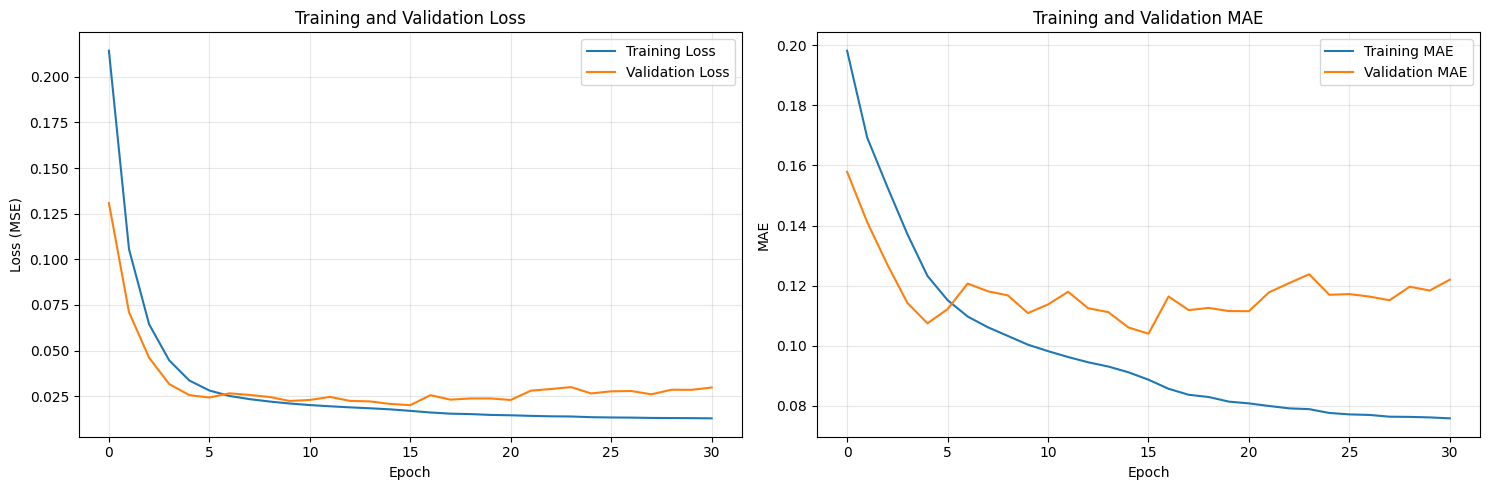


Training Summary:
   Final training loss: 0.012819
   Final validation loss: 0.029722
   Final training MAE: 0.075856
   Final validation MAE: 0.121996
   Total epochs trained: 31


In [7]:
# Plot training history
plot_training_history(history)

# Additional training metrics
print("\nTraining Summary:")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"   Final validation MAE: {history.history['val_mae'][-1]:.6f}")
print(f"   Total epochs trained: {len(history.history['loss'])}")

## Evaluate Model Performance

In [8]:
# Make predictions
print("Making predictions...")
gru_train_pred = gru_model.predict(X_train, batch_size=batch_size, verbose=0).flatten()
gru_val_pred = gru_model.predict(X_val, batch_size=batch_size, verbose=0).flatten()
gru_test_pred = gru_model.predict(X_test, batch_size=batch_size, verbose=0).flatten()

# Evaluate performance
gru_train_metrics = evaluate_model(y_train, gru_train_pred, "GRU (Training)")
gru_val_metrics = evaluate_model(y_val, gru_val_pred, "GRU (Validation)")
gru_test_metrics = evaluate_model(y_test, gru_test_pred, "GRU (Test)")

print("\nGRU evaluation completed.")

Making predictions...

GRU (Training) Performance:
  R² Score: 0.517238
  RMSE: 0.158039 (15.804% SOC)
  MAE: 0.119587 (11.959% SOC)

GRU (Validation) Performance:
  R² Score: 0.631163
  RMSE: 0.130447 (13.045% SOC)
  MAE: 0.104026 (10.403% SOC)

GRU (Test) Performance:
  R² Score: 0.611135
  RMSE: 0.138497 (13.850% SOC)
  MAE: 0.110589 (11.059% SOC)

GRU evaluation completed.


## Visualize Predictions

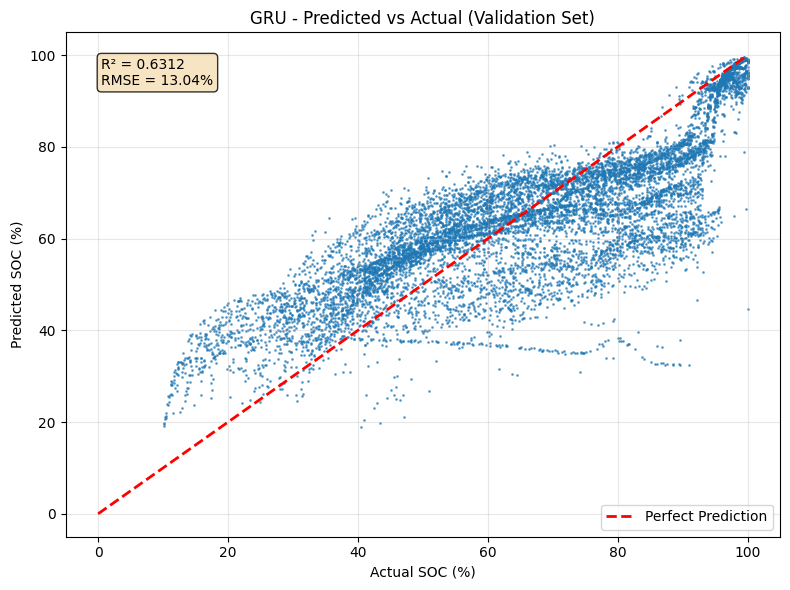

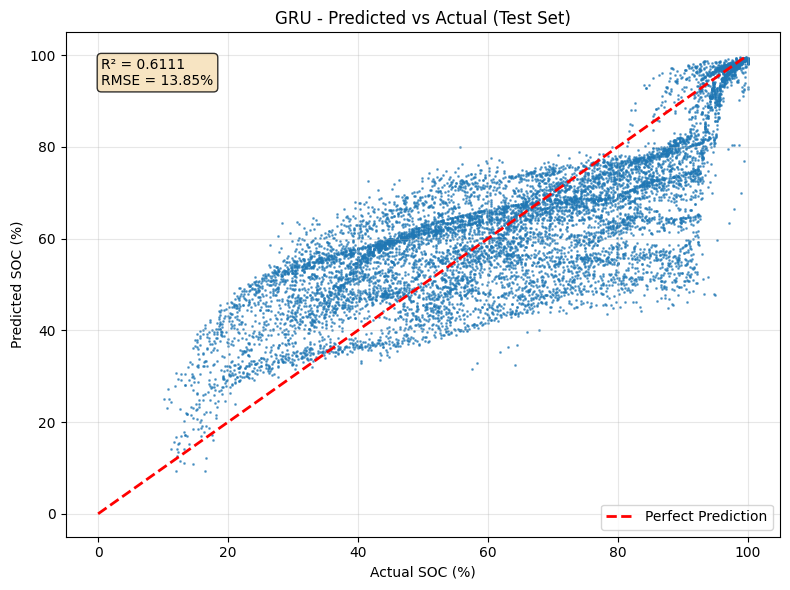

In [9]:
# Visualize predictions on validation set
plot_predictions(y_val, gru_val_pred, "GRU", "(Validation Set)")

# Visualize predictions on test set
plot_predictions(y_test, gru_test_pred, "GRU", "(Test Set)")

## Residual Analysis

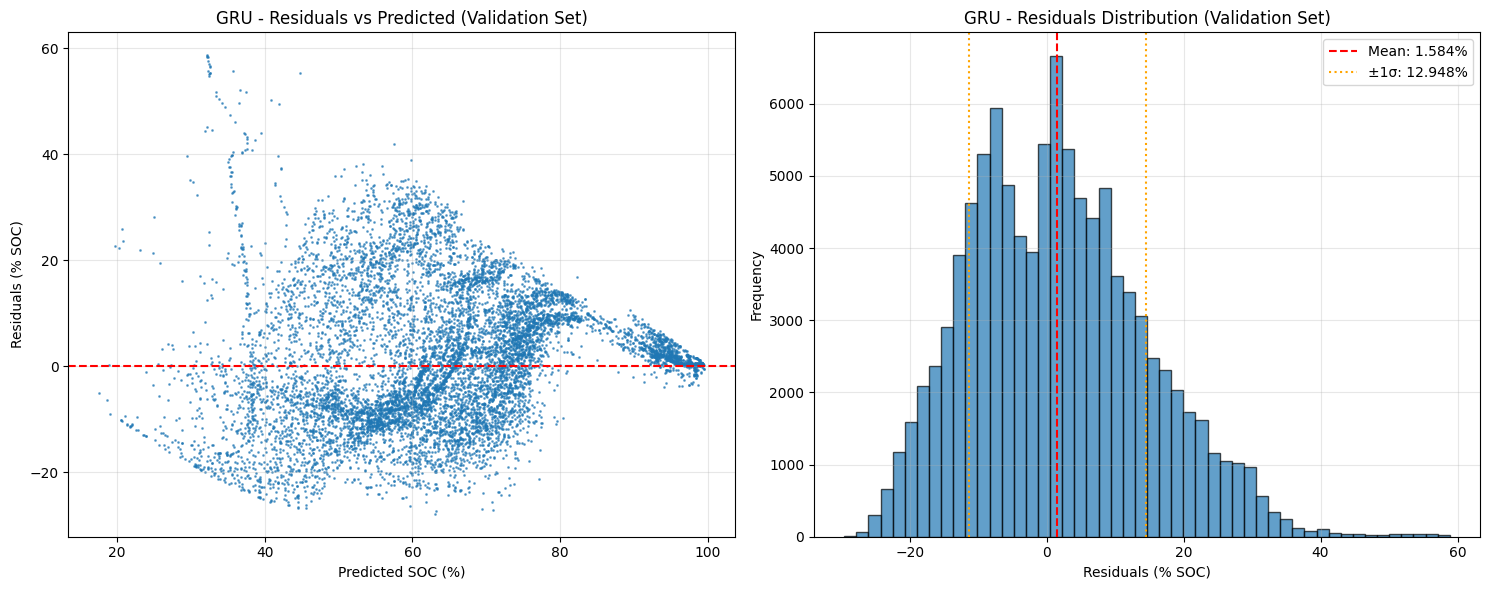

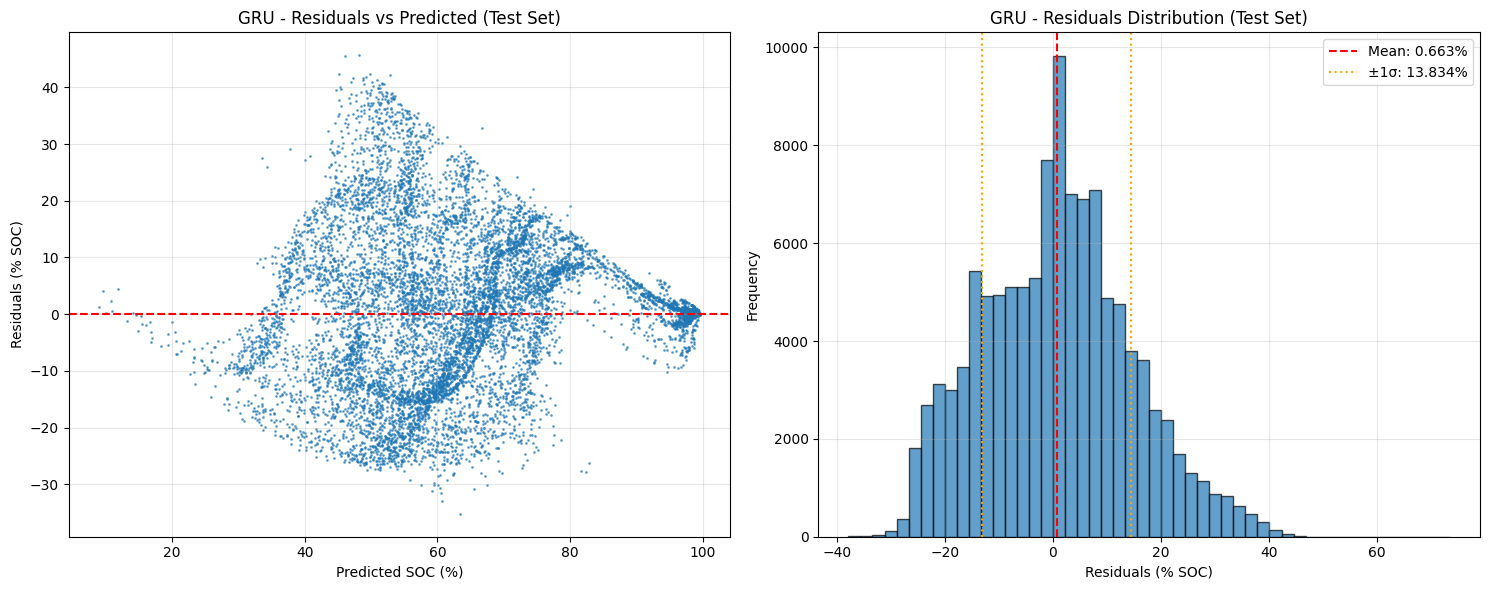

In [10]:
def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_pred_sample = y_pred[sample_idx]
        residuals_sample = residuals[sample_idx]
    else:
        y_pred_sample = y_pred
        residuals_sample = residuals
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred_sample * 100, residuals_sample, alpha=0.6, s=1)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted SOC (%)')
    axes[0].set_ylabel('Residuals (% SOC)')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Residuals (% SOC)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[1].axvline(x=mean_res, color='red', linestyle='--', label=f'Mean: {mean_res:.3f}%')
    axes[1].axvline(x=mean_res + std_res, color='orange', linestyle=':', label=f'±1σ: {std_res:.3f}%')
    axes[1].axvline(x=mean_res - std_res, color='orange', linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot residuals for validation and test sets
plot_residuals(y_val, gru_val_pred, "GRU", "(Validation Set)")
plot_residuals(y_test, gru_test_pred, "GRU", "(Test Set)")

## Compare with Baseline Models

Load and compare with results from notebooks 06, 07, and 08.

MODEL PERFORMANCE COMPARISON

Using 24 features with 20 timesteps

Model                  Train R²     Val R²    Test R²   Test RMSE (%)
---------------------------------------------------------------------------
Linear Regression             -          -   0.208879          19.756
Random Forest                 -          -   0.917825           6.367
XGBoost                       -          -   0.904824           6.852
1D CNN                        -          -   0.798880           9.958
LSTM                          -          -   0.330670          18.170
GRU                    0.517238   0.631163   0.611135          13.850


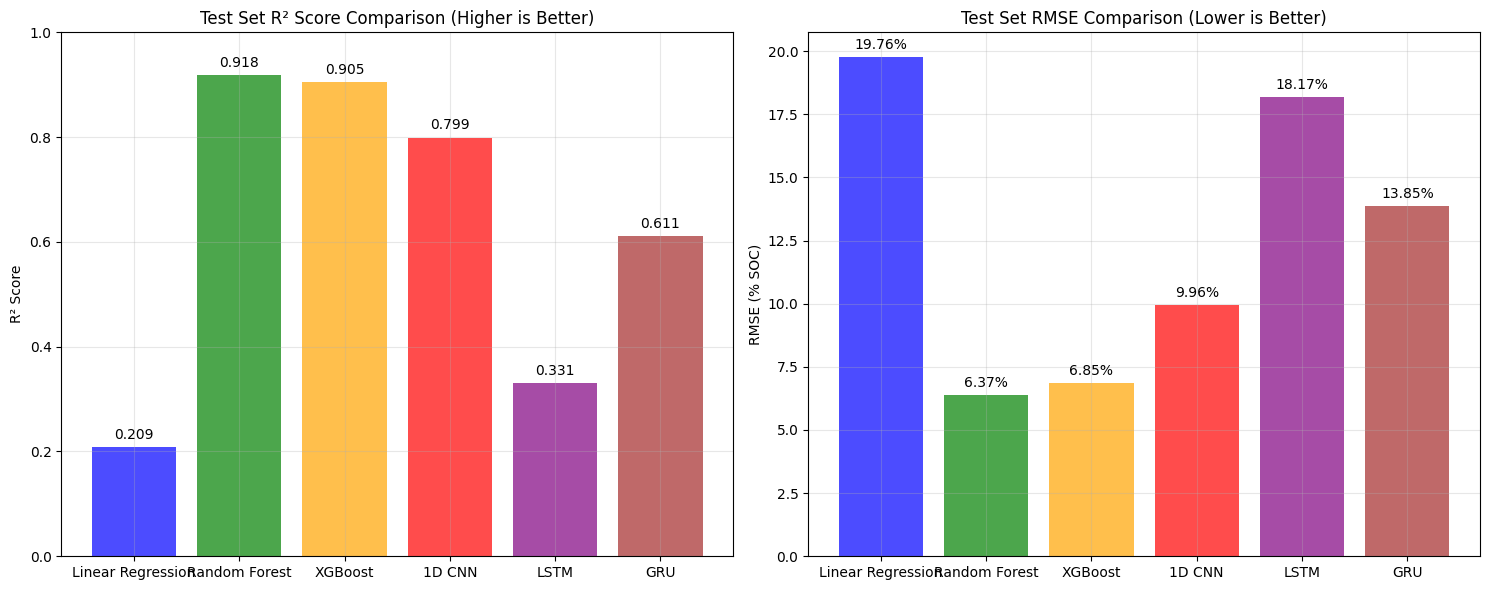

In [11]:
# Baseline results from notebooks 06, 07, and 08
baseline_results = {
    'Linear Regression': {'Test_R2': 0.208879, 'Test_RMSE_%': 19.756},
    'Random Forest': {'Test_R2': 0.917825, 'Test_RMSE_%': 6.367},
    'XGBoost': {'Test_R2': 0.904824, 'Test_RMSE_%': 6.852},
    '1D CNN': {'Test_R2': 0.798880, 'Test_RMSE_%': 9.958},
    'LSTM': {'Test_R2': 0.330670, 'Test_RMSE_%': 18.170}
}

# Add GRU results
gru_results = {
    'GRU': {
        'Training_R2': gru_train_metrics['r2'],
        'Training_RMSE_%': gru_train_metrics['rmse_percent'],
        'Validation_R2': gru_val_metrics['r2'],
        'Validation_RMSE_%': gru_val_metrics['rmse_percent'],
        'Test_R2': gru_test_metrics['r2'],
        'Test_RMSE_%': gru_test_metrics['rmse_percent']
    }
}

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"\nUsing {n_features} features with {sequence_length} timesteps\n")
print(f"{'Model':<20} {'Train R²':>10} {'Val R²':>10} {'Test R²':>10} {'Test RMSE (%)':>15}")
print("-"*75)

# Print baseline results
for model_name, metrics in baseline_results.items():
    print(f"{model_name:<20} {'-':>10} {'-':>10} {metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Print GRU results
for model_name, metrics in gru_results.items():
    print(f"{model_name:<20} {metrics['Training_R2']:>10.6f} {metrics['Validation_R2']:>10.6f} "
          f"{metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
models = list(baseline_results.keys()) + list(gru_results.keys())
test_r2 = [baseline_results[m]['Test_R2'] for m in baseline_results.keys()] + \
          [gru_results[m]['Test_R2'] for m in gru_results.keys()]
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

axes[0].bar(models, test_r2, color=colors, alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Test Set R² Score Comparison (Higher is Better)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])
for i, (model, score) in enumerate(zip(models, test_r2)):
    axes[0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# RMSE comparison
test_rmse = [baseline_results[m]['Test_RMSE_%'] for m in baseline_results.keys()] + \
            [gru_results[m]['Test_RMSE_%'] for m in gru_results.keys()]

axes[1].bar(models, test_rmse, color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE (% SOC)')
axes[1].set_title('Test Set RMSE Comparison (Lower is Better)')
axes[1].grid(True, alpha=0.3)
for i, (model, rmse) in enumerate(zip(models, test_rmse)):
    axes[1].text(i, rmse + 0.2, f'{rmse:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Summary

In [ ]:
print("="*80)
print("GRU MODEL TRAINING SUMMARY")
print("="*80)

print("\nDataset Configuration:")
print(f"   Total features available: {X_train_full.shape[2]}")
print(f"   Features used: {n_features}")
print(f"   Sequence length: {sequence_length} timesteps")
print(f"   Training sequences: {X_train.shape[0]:,}")
print(f"   Validation sequences: {X_val.shape[0]:,}")
print(f"   Test sequences: {X_test.shape[0]:,}")

print("\nModel Architecture:")
print(f"   Total parameters: {total_params:,}")
print(f"   GRU layers: 2 (40, 20 units)")
print(f"   Dense layers: 2 (16, 1 units)")
print(f"   Dropout rate: 0.3")
print(f"   Recurrent dropout: 0.2")
print(f"   L2 regularization: 0.002")

print("\nTraining Results:")
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Training time: {training_time/60:.2f} minutes")
print(f"   Best validation loss: {np.min(history.history['val_loss']):.6f}")

print("\nPerformance Summary:")
print(f"   Training R²: {gru_train_metrics['r2']:.6f}")
print(f"   Validation R²: {gru_val_metrics['r2']:.6f}")
print(f"   Test R²: {gru_test_metrics['r2']:.6f}")
print(f"   Test RMSE: {gru_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   Test MAE: {gru_test_metrics['mae_percent']:.3f}% SOC")

# Check for overfitting
train_val_gap = gru_train_metrics['r2'] - gru_val_metrics['r2']
status = "✅ Good" if train_val_gap < 0.05 else "⚠️ Mild" if train_val_gap < 0.1 else "❌ Severe"
print(f"\nOverfitting Analysis:")
print(f"   Train-Val R² gap: {train_val_gap:.4f} ({status})")
print(f"   Train-Test R² gap: {gru_train_metrics['r2'] - gru_test_metrics['r2']:.4f}")

# Compare with best baseline
best_baseline = 'Random Forest'
best_baseline_r2 = baseline_results[best_baseline]['Test_R2']
best_baseline_rmse = baseline_results[best_baseline]['Test_RMSE_%']

print(f"\nComparison with Best Baseline ({best_baseline}):")
print(f"   Baseline Test R²: {best_baseline_r2:.6f}")
print(f"   GRU Test R²: {gru_test_metrics['r2']:.6f}")
print(f"   R² Difference: {gru_test_metrics['r2'] - best_baseline_r2:+.6f}")
print(f"   Baseline Test RMSE: {best_baseline_rmse:.3f}% SOC")
print(f"   GRU Test RMSE: {gru_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   RMSE Difference: {gru_test_metrics['rmse_percent'] - best_baseline_rmse:+.3f}% SOC")

# Compare with other RNNs
lstm_r2 = baseline_results['LSTM']['Test_R2']
lstm_rmse = baseline_results['LSTM']['Test_RMSE_%']

print(f"\nComparison with LSTM:")
print(f"   LSTM Test R²: {lstm_r2:.6f}")
print(f"   GRU Test R²: {gru_test_metrics['r2']:.6f}")
print(f"   R² Difference: {gru_test_metrics['r2'] - lstm_r2:+.6f}")
print(f"   LSTM Test RMSE: {lstm_rmse:.3f}% SOC")
print(f"   GRU Test RMSE: {gru_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   RMSE Difference: {gru_test_metrics['rmse_percent'] - lstm_rmse:+.3f}% SOC")

if gru_test_metrics['r2'] > best_baseline_r2:
    print(f"\n✅ GRU outperforms all baseline models!")
elif gru_test_metrics['r2'] > lstm_r2:
    print(f"\n✅ GRU outperforms LSTM for sequential modeling.")
else:
    print(f"\nGRU performance is comparable to baseline models.")

## Save Model and Results

In [13]:
# Save the model
model_path = OUTPUT_DIR / 'final_gru_model.keras'
gru_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# Save results and metrics
results = {
    'model_type': 'GRU',
    'sequence_length': sequence_length,
    'n_features': n_features,
    'feature_names': available_realistic,
    'total_parameters': total_params,
    'training_time': training_time,
    'epochs_trained': len(history.history['loss']),
    'metrics': {
        'train': gru_train_metrics,
        'val': gru_val_metrics,
        'test': gru_test_metrics
    },
    'history': history.history
}

results_path = OUTPUT_DIR / 'gru_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✅ Results saved to {results_path}")

✅ Model saved to processed_data/final_gru_model.keras
✅ Results saved to processed_data/gru_results.pkl
